- 참조

  - 텐서플로우 공식 홈페이지  
    https://www.tensorflow.org/tutorials/generative/cyclegan


# CycleGAN

- 조건부 GAN을 사용하여 페어링되지 않은 이미지 대 이미지 변환

- 한 이미지 도메인의 특성을 캡처하고 이러한 특성을 다른 이미지 도메인으로 변환 할 수있는 방법을 알아낼 수있는 방법을 제안

- Pix2Pix와의 차이는 추가 손실 함수와 페어링되지 않은 훈련 데이터의 사용한다는 점

- CycleGAN은 a cycle consistency loss를 사용하여 쌍을 이루는 데이터 없이도 훈련을 가능하게 함  
  즉, 소스 및 대상 도메인 간의 일대일 매핑없이 한 도메인에서 다른 도메인으로 변환 가능

- 이것은 사진 향상, 이미지 색상 화, 스타일 전송 등과 같은 많은 흥미로운 작업을 수행 할 수있는 가능성을 열어줌  
  필요한 것은 소스와 대상 데이터 세트 (단순히 이미지 디렉토리)뿐임

  <img src="https://www.tensorflow.org/tutorials/generative/images/horse2zebra_1.png">

  <img src="https://www.tensorflow.org/tutorials/generative/images/horse2zebra_2.png">

- Pix2Pix의 generator와 discriminator를 가져올 수 있는 패키지 설치
* https://github.com/tensorflow/examples.git

In [1]:
pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE

## 입력 파이프 라인 

- 학습 데이터셋에 random jittering을 적용

  - 이는 과적합을 방지하는 몇 가지 이미지 확대 기술

  - Pix2Pix와 유사

    - 임의 jittering에서 286x286 크기의 이미지가 무작위로 256x256으로 잘림

    - 랜덤 미러링에서는 이미지가 좌우로 무작위로 반전됨

In [3]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteLNB2DK/cycle_gan-trainA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteLNB2DK/cycle_gan-trainB.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteLNB2DK/cycle_gan-testA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteLNB2DK/cycle_gan-testB.tfrecord


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [5]:
def random_crop(image):
  cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  return cropped_image

- 이미지 값을 [-1, 1] 사이의 값으로 정규화

In [6]:
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [7]:
def random_jitter(image):
  image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = random_crop(image)
  image = tf.image.random_flip_left_right(image)
  return image

In [8]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [9]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [10]:
train_horses = train_horses.map(preprocess_image_train,
                                num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)
train_zebras = train_zebras.map(preprocess_image_train,
                                num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

test_horses = test_horses.map(preprocess_image_test,
                              num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)
test_zebras = test_zebras.map(preprocess_image_test,
                              num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

In [11]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

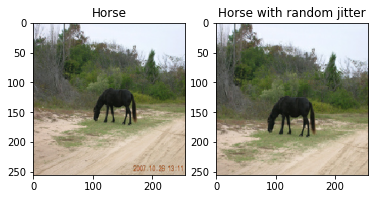

In [12]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

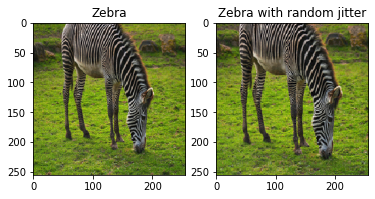

In [13]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

## Pix2Pix 모델 로드 및 재사용

- Pix2Pix에서 사용된 generator와 discriminator를 가져옴

- Pix2Pix와의 차이점

  - CycleGAN은 배치 정규화 대신 인스턴스 정규화 사용

  - 논문에서는 ResNet기반 생성기를 사용하지만 본 코드에서는 UNet 생성기를 기반으로 함

- 2 개의 생성기 (G 및 F)와 2 개의 판별 기 (X 및 Y)가 여기에서 훈

  - 생성기 `G` 는 이미지 `X`를 이미지 `Y`로 변환하는 방법을 학습 $(G : X -> Y)$

  - 생성기 `F`는 이미지 `Y`를 이미지 `X`로 변환하는 방법을 학습 $(F : Y -> X)$

  - 판별기 `D_X`는 이미지 `X`와 생성 된 이미지 `X`( `F(Y)` )를 구별하는 방법을 학습

  -  판별기 `D_Y` 는 이미지 `Y`와 생성 된 이미지 `Y`( `G(X)` )를 구별하는 `D_Y` 학습

  <img src="https://www.tensorflow.org/tutorials/generative/images/cyclegan_model.png">

In [14]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

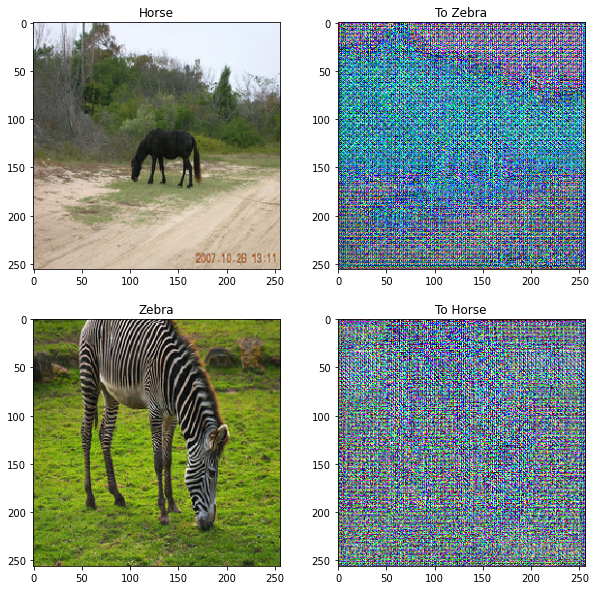

In [15]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(10, 10))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast +0.5)

plt.show()

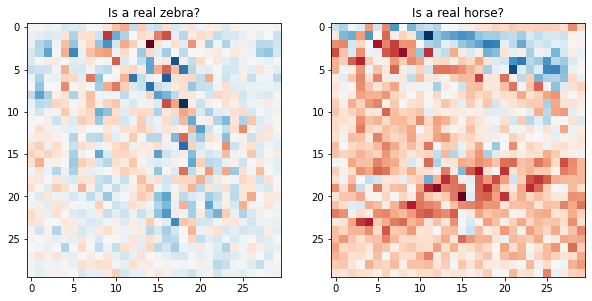

In [16]:
plt.figure(figsize=(10, 10))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_y(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

## 손실 기능

- CycleGAN에서는 학습 할 쌍데이터가 없으므로 입력 `x` 및 대상 `y` 쌍이 학습 중에 의미가 있다는 보장이 없음  

- 따라서 네트워크가 올바른 매핑을 학습하도록하기 위해 논문 저자는 주기 일관성 손실을 제안

- 판별기 손실과 생성기 손실은 pix2pix 에서 사용되는 것과 유사

In [17]:
LAMBDA = 10

In [18]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

In [20]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

### 주기 일관성

- 주기 일관성은 결과가 원래 입력에 가까워 야 함을 의미

- 예를 들어, 한 문장을 영어에서 프랑스어로 번역 한 다음 다시 프랑스어에서 영어로 번역하는 경우 결과 문장은 원래 문장과 동일해야 함

- 주기 일관성 손실에서

  - $X$이미지는 생성 된 $hatY$이미지를 생성하는 $G$생성기를 통해 전달

  - 생성 된 이미지 $hatY$는 순환 이미지 $hatX$을 생성하는 생성기 $F$를 통해 전달

  - 평균 절대 오차는 $X$와 $hatX$사이에서 계산됨
  
  $\quad forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$

  $\quad backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$

  <img src="https://www.tensorflow.org/tutorials/generative/images/cycle_loss.png">

In [21]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss1

- 위와 같이 $G$ 생성기는 $X$ 이미지를 $Y$ 이미지로 변환

- ID 손실은 $Y$ 이미지를 생성기 $G$ 에 공급하면 실제 이미지 $Y$ 또는 $Y$ 에 가까운 이미지를 생성해야 한다고 말함

- 말에서 zebra-to-horse 모델을 실행하거나 얼룩말에서 horse-to-zebra 모델을 실행하는 경우 이미지에 이미 대상 클래스가 포함되어 있으므로 이미지를 많이 수정해서는 안됨


$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [22]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

- 모든 생성기와 판별기에 대한 옵티마이저 초기화

In [23]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## 체크 포인트 설정

In [24]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

## 학습

- 논문에서는 `Epochs=200`으로 설정

- 여기서는 `40`으로 설정. 예측이 덜 정확할 수 있음

In [25]:
EPOCHS = 40

In [26]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))
  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Prediction Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
    
  plt.show()

- 학습 과정 
  
  - 예측을 가져옴

  - 손실을 계산

  - 역 전파를 사용하여 기울기를 계산

  - 옵티마이저에 그라디언트를 적용

In [27]:
@tf.function
def train_step(real_x, real_y):
  with tf.GradientTape(persistent=True) as tape:
    fake_y = generator_g(real_x, training=True)
    cycled_y = generator_f(fake_y, training=True)
    fake_x = generator_f(real_y, training=True)
    cycled_x = generator_g(fake_x, training=True)

    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)
    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

- 학습 소요시간 매우 오래 걸림

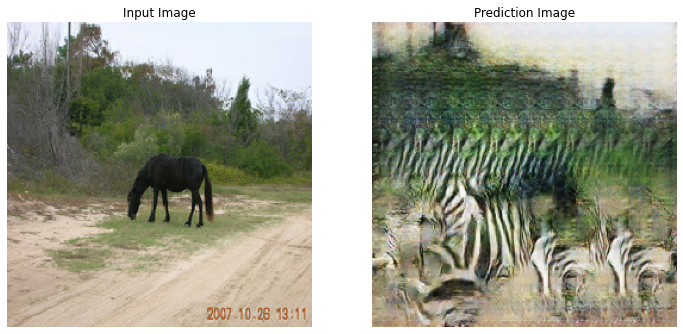

Saving checkpoint for epoch 40 at ./checkpoints/train/ckpt-8
Time taken for epoch 40 is 253.9935986995697 sec



In [28]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print('.', end='')
    n += 1

  clear_output(wait=True)

  generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

  print('Time taken for epoch {} is {} sec\n'.format(epoch+1, time.time()-start))

## 테스트 데이터셋을 사용하여 생성

In [29]:
for inp in test_horses.take(5):
  generate_images(generator_g, inp)

Output hidden; open in https://colab.research.google.com to view.